<a href="https://colab.research.google.com/github/KingJulien0709/RowingAnalytics/blob/main/rowing_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install ultralytics
from google.colab import drive
drive.mount('/content/drive')
from ultralytics import YOLO

model = YOLO("yolo11n-pose.pt")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.5/913.5 kB 9.5 MB/s eta 0:00:00
Mounted at /content/drive
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.97M/5.97M [00:00<00:00, 68.8MB/s]


In [ ]:
import os
import cv2

video_path= "/content/drive/My Drive/ergo_berg.mp4" # "

FRAME_RATE = 0
FRAME_COUNT = 0

cap  = cv2.VideoCapture(video_path)

if not cap.isOpened():
  print("Error opening video file")
else:
  FRAME_RATE = round(cap.get(cv2.CAP_PROP_FPS))
  FRAME_COUNT = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

cap.release()



In [ ]:
#video_path = "/content/drive/My Drive/ergo_short2_small.mp4"
#"/content/drive/My Drive/video_row2.mp4"
result = model.track(video_path, save=True, conf =0.8,name ="run", imgsz=(320, 224))



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/431) /content/drive/My Drive/ergo_berg.mp4: 128x224 1 person, 44.1ms
video 1/1 (frame 2/431) /content/drive/My Drive/ergo_berg.mp4: 128x224 1 person, 37.9ms
video 1/1 (frame 3/431) /content/drive/My Drive/ergo_berg.mp4: 128x224 1 person, 57.1ms
video 1/1 (frame 4/431) /content/drive/My Drive/ergo_berg.mp4: 128x224 1 person, 39.0ms
video 1/1 (frame 5/431) /content/drive/My Drive/ergo_berg.mp4: 128x224 1 person, 53.7ms
video 1/1 (frame

In [ ]:
#print(result[0].cpu)


In [ ]:
def interpolate_wrong_numbers(keyframes):
  error_values = torch.any(keyframes[:, :,0:2]==0, dim=(1,2))
  #selected_joints_keyframes[error_values] = torch.
  keyframe_nparray = keyframes.numpy()
  #for i in range(keyframe_nparray.shape[0]):
   # for j in range(keyframe_nparray.shape[1]):


431
torch.Size([431, 6, 2])
torch.Size([431, 6, 2])
tensor([0.2931, 0.2870, 0.2893, 0.2898, 0.2858, 0.2889, 0.2981, 0.2893, 0.2893, 0.2939, 0.3005, 0.3021, 0.3040, 0.3071, 0.3049, 0.3059, 0.3238, 0.3181, 0.3214, 0.3231, 0.3167, 0.3201, 0.3285, 0.3350, 0.3440, 0.3313, 0.3335, 0.3517, 0.3534, 0.3542, 0.3557, 0.3604, 0.3687, 0.3661, 0.3686, 0.3700, 0.3726, 0.3688, 0.3665,
        0.3641, 0.3630, 0.3628, 0.3603, 0.3576, 0.3458, 0.3480, 0.3385, 0.3370, 0.3346, 0.3305, 0.3220, 0.3210, 0.3107, 0.3062, 0.2991, 0.2964, 0.2993, 0.3037, 0.2905, 0.2858, 0.2855, 0.2835, 0.2850, 0.2954, 0.2854, 0.2755, 0.2806, 0.2599, 0.2604, 0.2774, 0.2675, 0.2639, 0.2537, 0.2792, 0.2751, 0.2656, 0.2634, 0.2802,
        0.2728, 0.3040, 0.3056, 0.3122, 0.3132, 0.3172, 0.3203, 0.3236, 0.2793, 0.2810, 0.2824, 0.3098, 0.3052, 0.3043, 0.3047, 0.2802, 0.2733, 0.2794, 0.2826, 0.2824, 0.2837, 0.2856, 0.2980, 0.2985, 0.3011, 0.2984, 0.3006, 0.3085, 0.3180, 0.3136, 0.3116, 0.3282, 0.3295, 0.3515, 0.3535, 0.3599, 0.3624, 0.36

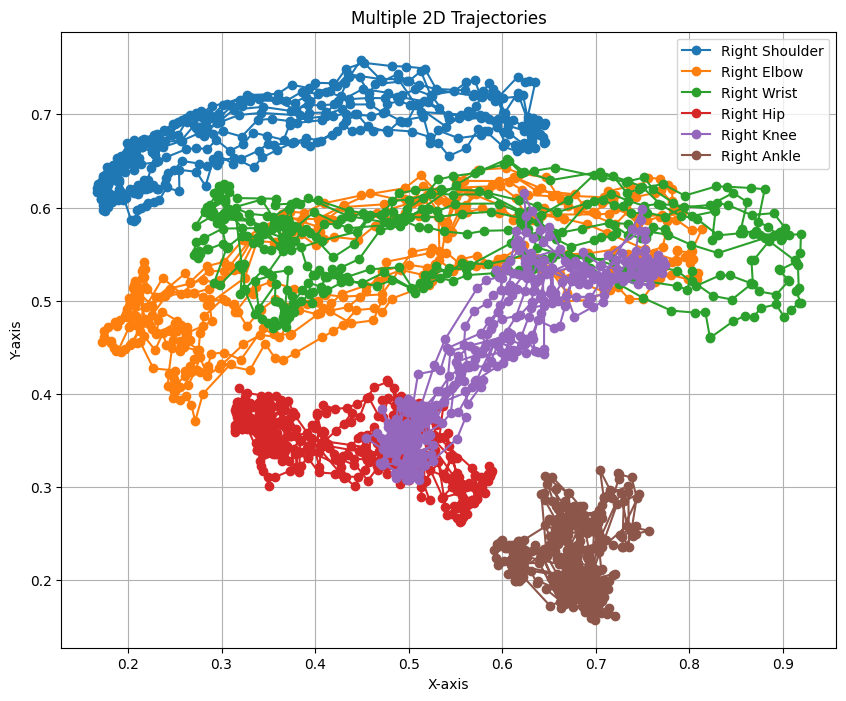

In [ ]:
import torch
import matplotlib.pyplot as plt

body_parts = {
    0: "Nose",
    1: "Left Eye",
    2: "Right Eye",
    3: "Left Ear",
    4: "Right Ear",
    5: "Left Shoulder",
    6: "Right Shoulder",
    7: "Left Elbow",
    8: "Right Elbow",
    9: "Left Wrist",
    10: "Right Wrist",
    11: "Left Hip",
    12: "Right Hip",
    13: "Left Knee",
    14: "Right Knee",
    15: "Left Ankle",
    16: "Right Ankle"
}
print(len(result))
result_copy = []



normalized_keyframes_tensor = [result[0].keypoints.xyn for result in result]
selcted_joints = [6, 8, 10, 12, 14, 16]

#print(normalized_keyframes_tensor[:][0].shape)

#keyframe = normalized_keyframes_tensor[0]#.squeeze(0)
#print(keyframe.shape)
#selected_joints_keyframe = keyframe[selcted_joints]




selected_joints_keyframes = torch.stack([n_k_t.squeeze(0)[selcted_joints] for n_k_t in normalized_keyframes_tensor])
error_values = torch.any(selected_joints_keyframes[:, :,0:2]==0, dim=(1,2))
filtered_keyframes = selected_joints_keyframes[~error_values]
#selected_joints_keyframes[error_values] =
print(filtered_keyframes.shape)

print(selected_joints_keyframes.shape)


#plot the trajectories
print(filtered_keyframes[:,0,1])
trajectories = { body_parts[selcted_joints[i]]: (filtered_keyframes[:,i,0], filtered_keyframes[:,i,1]) for i in range(len(selcted_joints))}

#trajectories = {
#    "joint_0": (filtered_keyframes[:,0,0], filtered_keyframes[:,0,1]),
#    "joint_1": (filtered_keyframes[:,1,0], filtered_keyframes[:,1,1]),
#    "joint_2": (filtered_keyframes[:,2,0], filtered_keyframes[:,2,1]),
 #   "joint_8": (filtered_keyframes[:,3,0], filtered_keyframes[:,3,1]),
#}


plt.figure(figsize=(10, 8))
for label, (x, y) in trajectories.items():
    plt.plot(x.cpu(), 1-y.cpu(), marker='o', label=label)

# Customizing the plot
plt.title("Multiple 2D Trajectories")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.legend()  # Add legend to distinguish paths
plt.show()

In [ ]:
def calculate_angles_for_joint(keyframes, angle_pairs):
  v1_single_v = keyframes[:, angle_pairs[0, 0]] - keyframes[:, angle_pairs[0, 1]]
  v2_single_v = keyframes[:, angle_pairs[1, 0]] - keyframes[:, angle_pairs[1, 1]]
  angles = torch.acos(torch.sum(v1_single_v * v2_single_v, dim=1) / (torch.norm(v1_single_v, dim=1) * torch.norm(v2_single_v, dim=1)))*180/3.14
  return angles

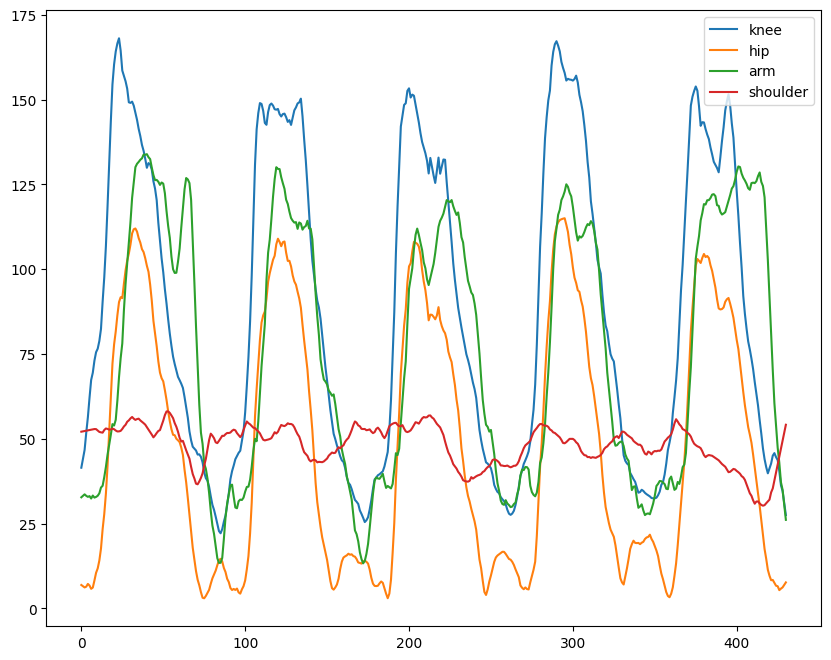

In [ ]:
#calculate distances between keypoints
from scipy.signal import savgol_filter


selected_angle_pairs = torch.tensor([
    [[4, 5],[4, 3]], #knee angle
    [[3,2],[3,4]], #hip angle
    [[1,2],[1,0]], #arm angle
    [[2,1],[2,3]], #shoulder angle
])



timestep = 31
anglepair = 0
#v1_single_v = filtered_keyframes[:, selected_angle_pairs[anglepair, 0, 0]] - filtered_keyframes[:, selected_angle_pairs[anglepair, 0, 1]]
#v2_single_v = filtered_keyframes[:, selected_angle_pairs[anglepair, 1, 0]] - filtered_keyframes[:, selected_angle_pairs[anglepair, 1, 1]]
#angles = torch.acos(torch.sum(v1_single_v * v2_single_v, dim=1) / (torch.norm(v1_single_v, dim=1) * torch.norm(v2_single_v, dim=1)))*180/3.14
#angles =

angles_knee = calculate_angles_for_joint(filtered_keyframes, selected_angle_pairs[0])
angles_hip = calculate_angles_for_joint(filtered_keyframes, selected_angle_pairs[1])
angles_arm = calculate_angles_for_joint(filtered_keyframes, selected_angle_pairs[2])
angles_shoulder = calculate_angles_for_joint(filtered_keyframes, selected_angle_pairs[3])

window_length = FRAME_RATE // 5 #for consistent smoothing adjust the windowlenght to the framerate
smoothed_angles_knee = savgol_filter(angles_knee.cpu().numpy(), window_length=window_length, polyorder=1)
smoothed_angles_hip = savgol_filter(angles_hip.cpu().numpy(), window_length=window_length, polyorder=1)
smoothed_angles_arm = savgol_filter(angles_arm.cpu().numpy(), window_length=window_length, polyorder=1)
smoothed_angles_shoulder = savgol_filter(angles_shoulder.cpu().numpy(), window_length=window_length*3, polyorder=1)

plt.figure(figsize=(10, 8))
plt.plot(smoothed_angles_knee)
plt.plot(smoothed_angles_hip)
plt.plot(180-smoothed_angles_arm) #show "reversed" angle to allign for phase analysis
plt.plot(smoothed_angles_shoulder)
#plt.plot(angles_arm.cpu())
#plt.plot(angles_shoulder.cpu())
plt.legend(["knee", "hip", "arm" ,"shoulder"])
plt.show() #sharp peakes in the plot show the removed values/values beeing out of the camera view -> interpolate should be better than complety removing.

#print(angles_hip)


#print(v1_single_v.shape)
#print(v2_single_v.shape)

#distance = torch.cdist(filtered_keyframes, filtered_keyframes)
#print(distance.shape)
#distances = [distance for

In [ ]:
import numpy as np

#function to plot a single stroke
def plot_single_stroke(stroke,labels, normalize = False, derivativ=False):
  plt.figure(figsize=(10, 8))
  for i in range(len(stroke)):
    if derivativ:
      stroke[i] = np.diff(savgol_filter(stroke[i].copy(), window_length=FRAME_RATE//3, polyorder=1))
      #stroke[i] = np.diff(savgol_filter(stroke[i].copy(), window_length=FRAME_RATE//2, polyorder=1)) # for 2. order derivative
    if normalize:
      min_value = np.min(stroke[i])
      max_value = np.max(stroke[i])
      stroke[i] = (stroke[i] - min_value) / (max_value - min_value)
      plt.plot(stroke[i])
    else:
      plt.plot(stroke[i])
  plt.legend(labels)
  plt.show()

In [ ]:
#function to split rowing sequence into strokes
#using the most significant angle for stroke seperation

#gradient
def extract_stroke_sequences_gradient(knee_angles):
  oversmoothed_window_lenth = round(1.25*FRAME_RATE)
  oversmoothing_knee_angles = savgol_filter(knee_angles.copy(), window_length=oversmoothed_window_lenth, polyorder=1) #additional smoothing for clear maxima and minima
  dx = np.diff(oversmoothing_knee_angles)
  dxx = np.diff(dx)
  turn_points = np.where(np.diff(np.sign(dx)) != 0)[0]
  maxima = turn_points[np.where(dxx[turn_points] < 0)]
  minima = turn_points[np.where(dxx[turn_points] > 0)]

  start_points = minima.tolist()
  #adjustements for beiginning and ending
  if maxima[0] < minima[0]:
    start_points.insert(0, 0)
  if minima[-1] < maxima[-1]:
    start_points.append(len(oversmoothing_knee_angles)-1)

  return np.array(start_points)


5


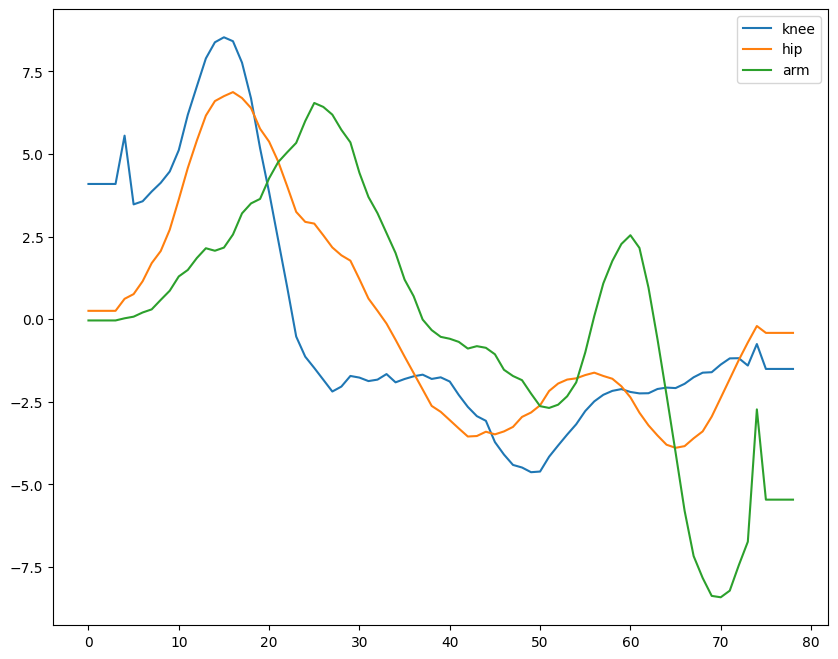

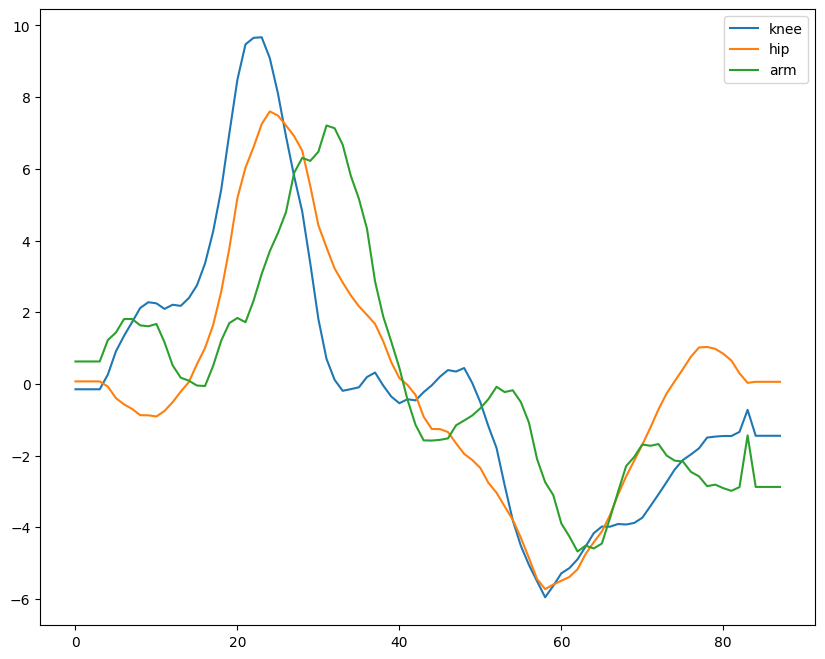

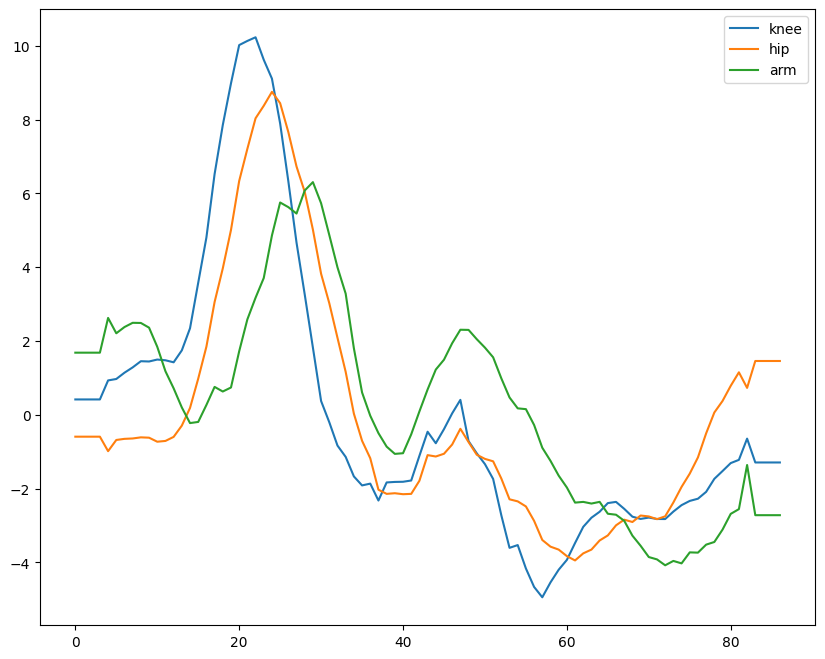

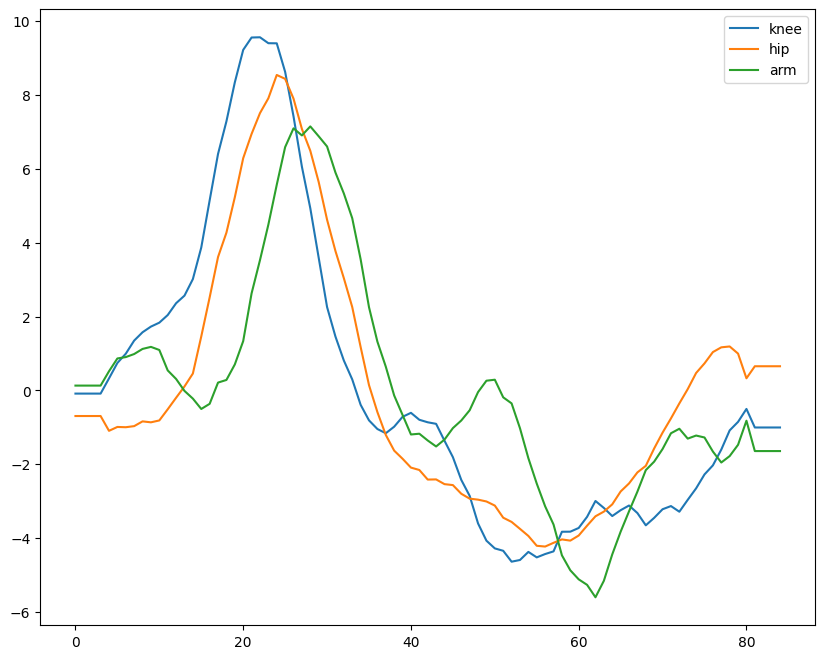

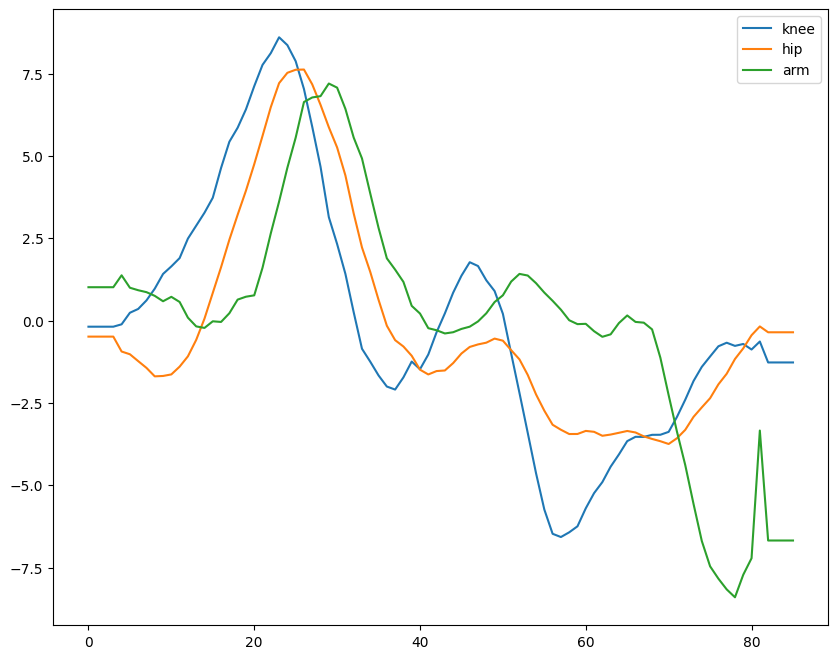

In [ ]:
#divide in single strokes
from scipy.signal import find_peaks
import numpy as np

##find local minima and maxima, use only minima
min_peaks = extract_stroke_sequences_gradient(smoothed_angles_knee)

##divide into single strokes
strokes = []

#print(min_peaks)
for i in range(len(min_peaks)-1):
  smoothed_angles_knee_slice = smoothed_angles_knee[min_peaks[i]:min_peaks[i+1]]
  smoothed_angles_hip_slice = smoothed_angles_hip[min_peaks[i]:min_peaks[i+1]]
  smoothed_angles_arm_slice = 180-smoothed_angles_arm[min_peaks[i]:min_peaks[i+1]] #invert arm agle for better visulisation
  #smoothed_angles_shoulder_slice = smoothed_angles_shoulder[min_peaks[i]:min_peaks[i+1]]
  strokes.append([smoothed_angles_knee_slice, smoothed_angles_hip_slice, smoothed_angles_arm_slice])#, smoothed_angles_shoulder_slice])
print(len(strokes))


#plot_single_stroke(strokes[2], ["knee", "hip", "arm"], normalize=True)
for stroke in strokes:
  plot_single_stroke(stroke.copy(), ["knee", "hip", "arm"], normalize=False,derivativ=True)

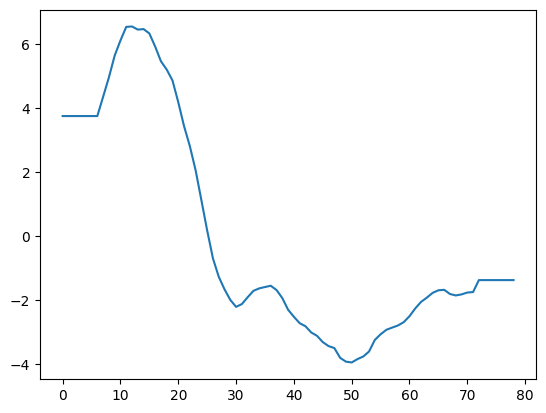

maxima: 12
minima: 50


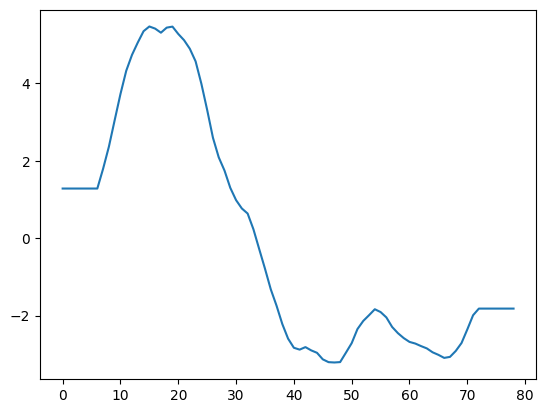

maxima: 15
minima: 47


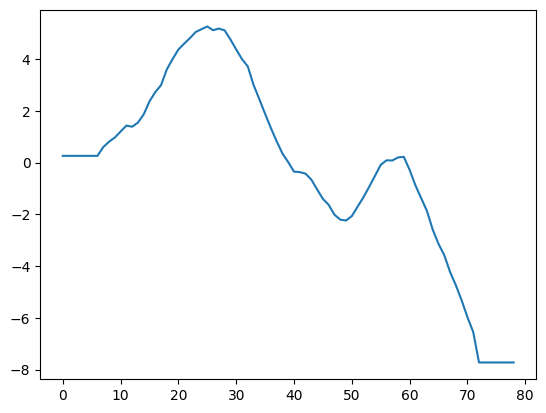

maxima: 25
minima: 73


In [ ]:
##analyse stroke
#basic timing analysis with first order derivativ maxima and minima
def analyse_stroke(stroke):
  for i in range(len(stroke)):
    dx = np.diff(savgol_filter(stroke[i].copy(), window_length=FRAME_RATE//2, polyorder=1))
    plt.plot(dx)
    plt.show()
    maxima = np.argmax(dx)
    minima = np.argmin(dx)
    print(f"maxima: {maxima}")
    print(f"minima: {minima}")





analyse_stroke(strokes[0])
